In [17]:
import numpy as np
import pandas as pd

from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, r2_score

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

sns.set_theme()

font = {'family' : 'Microsoft Yahei',
              'size'   : 10}
matplotlib.rc('font', **font)

plt.rcParams['axes.edgecolor'] = 'black'

In [18]:
data_ = pd.read_excel("dataset.xlsx")
index = []
for row in range(122):
    for j in range(4):
        index.append(row + 122*j)
data = data_.loc[index].reset_index(drop=True)
month_flag = data["月份"]
data.drop(columns=["年份", "月份"], inplace=True)
data

,土壤蒸发量(mm),"低层植被(LAIL,m2/m2)",植被指数(NDVI),径流量(m3),降水量(mm),深度(cm),平均风速(knots),平均气温(℃),当月湿度(mm),标签(mm)
0,0.61,0.63600,0.002,0.0,2.29,10,5.52,-22.94,13.73,13.00
1,0.61,0.63600,0.002,0.0,2.29,40,5.52,-22.94,30.87,30.87
2,0.61,0.63600,0.002,0.0,2.29,100,5.52,-22.94,42.79,42.79
3,0.61,0.63600,0.002,0.0,2.29,200,5.52,-22.94,168.56,168.56
4,0.86,0.65200,0.002,0.0,2.29,10,6.01,-17.86,13.00,12.60
...,...,...,...,...,...,...,...,...,...,...
483,0.44,0.63638,0.010,430650.0,607.31,200,4.37,-17.09,164.48,164.48
484,0.27,0.65073,0.010,280800.0,796.04,10,5.30,-17.93,12.10,14.96
485,0.27,0.65073,0.010,280800.0,796.04,40,5.30,-17.93,52.14,52.13
486,0.27,0.65073,0.010,280800.0,796.04,100,5.30,-17.93,93.45,93.44


In [19]:
## 标准化
data_mean, data_std = data.mean(axis=0), data.std(axis=0)
data = (data - data_mean) / data_std
data

,土壤蒸发量(mm),"低层植被(LAIL,m2/m2)",植被指数(NDVI),径流量(m3),降水量(mm),深度(cm),平均风速(knots),平均气温(℃),当月湿度(mm),标签(mm)
0,-0.953038,-1.141814,-1.599858,-1.303265,-0.546514,-1.066602,-0.843169,-1.845478,-0.953981,-0.969478
1,-0.953038,-1.141814,-1.599858,-1.303265,-0.546514,-0.653724,-0.843169,-1.845478,-0.662291,-0.665156
2,-0.953038,-1.141814,-1.599858,-1.303265,-0.546514,0.172033,-0.843169,-1.845478,-0.459436,-0.462161
3,-0.953038,-1.141814,-1.599858,-1.303265,-0.546514,1.548294,-0.843169,-1.845478,1.680929,1.679673
4,-0.927402,-0.998648,-1.599858,-1.303265,-0.546514,-1.066602,-0.365988,-1.489934,-0.966404,-0.976290
...,...,...,...,...,...,...,...,...,...,...
483,-0.970470,-1.138414,-1.545818,-0.544448,3.678899,1.548294,-1.963084,-1.436043,1.611495,1.610192
484,-0.987902,-1.010012,-1.545818,-0.808488,4.996975,-1.066602,-1.057414,-1.494833,-0.981721,-0.936100
485,-0.987902,-1.010012,-1.545818,-0.808488,4.996975,-0.653724,-1.057414,-1.494833,-0.300317,-0.303103
486,-0.987902,-1.010012,-1.545818,-0.808488,4.996975,0.172033,-1.057414,-1.494833,0.402701,0.400397


特征相关性

<AxesSubplot:>

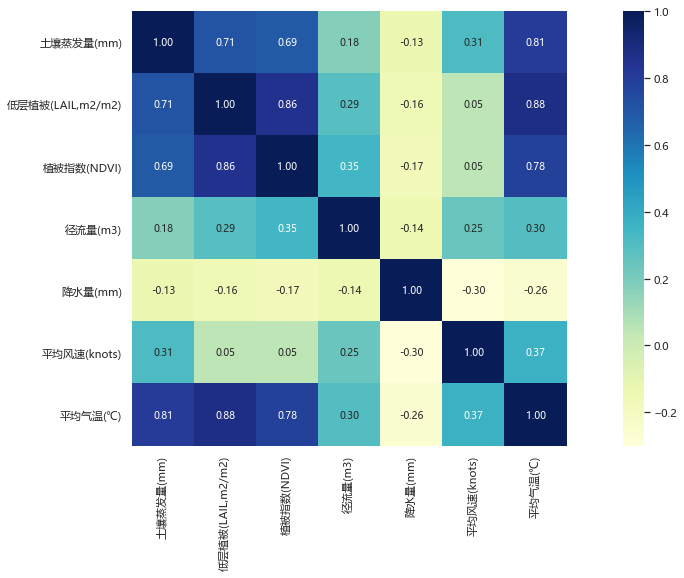

In [20]:
plt.figure(figsize=(20, 8))
sns.heatmap(data.drop(columns=["深度(cm)", "当月湿度(mm)", "标签(mm)"]).corr(), annot=True, square=True, fmt=".2f", cmap='YlGnBu')

训练

In [21]:
def transform(y):
    return y * data_std[-1] + data_mean[-1]


def cal_metric(label, pred):
    label = transform(label)
    pred = transform(pred)
    print(f"mae: {mean_absolute_error(label, pred)}")
    print(f"R2: {r2_score(label, pred)}")


def mae_scorer(estimator, X, y):
    y_pred = estimator.predict(X)
    mae = mean_absolute_error(transform(y), transform(y_pred))
    return mae

def r2_scorer(estimator, X, y):
    y_pred = estimator.predict(X)
    r2 = r2_score(transform(y), transform(y_pred))
    return r2

In [22]:
feature, label = data.drop(columns=["标签(mm)"]), data["标签(mm)"]
X_train, X_test, y_train, y_test = train_test_split(feature, label, test_size=0.2, shuffle=False)

In [23]:
mlp = MLPRegressor((32, 16,), batch_size=16, learning_rate_init=0.002, 
                    learning_rate="adaptive", max_iter=1500, random_state=518,
                    verbose=False, tol=1e-10, n_iter_no_change=100)

In [292]:
# 五折交叉验证
mae_cv = cross_val_score(mlp, feature, label, cv=5, scoring=mae_scorer, n_jobs=-1)
print(mae_cv)
print(mae_cv.mean())

r2_cv = cross_val_score(mlp, feature, label, cv=5, scoring=r2_scorer, n_jobs=-1)
print(r2_cv)
print(r2_cv.mean())

[2.25334349 1.92832734 2.35723373 1.94845789 2.51945113]
2.2013627177849266
[0.99682377 0.99764155 0.99628012 0.9977998  0.99528928]
0.9967669049946855


In [24]:
model = mlp.fit(X_train, y_train)

In [25]:
cal_metric(y_test, model.predict(X_test))

mae: 2.293791802740358
R2: 0.9962220861919479


损失曲线, 误差曲线, R2曲线

Text(0.5, 1.0, 'R2 =  0.9962')

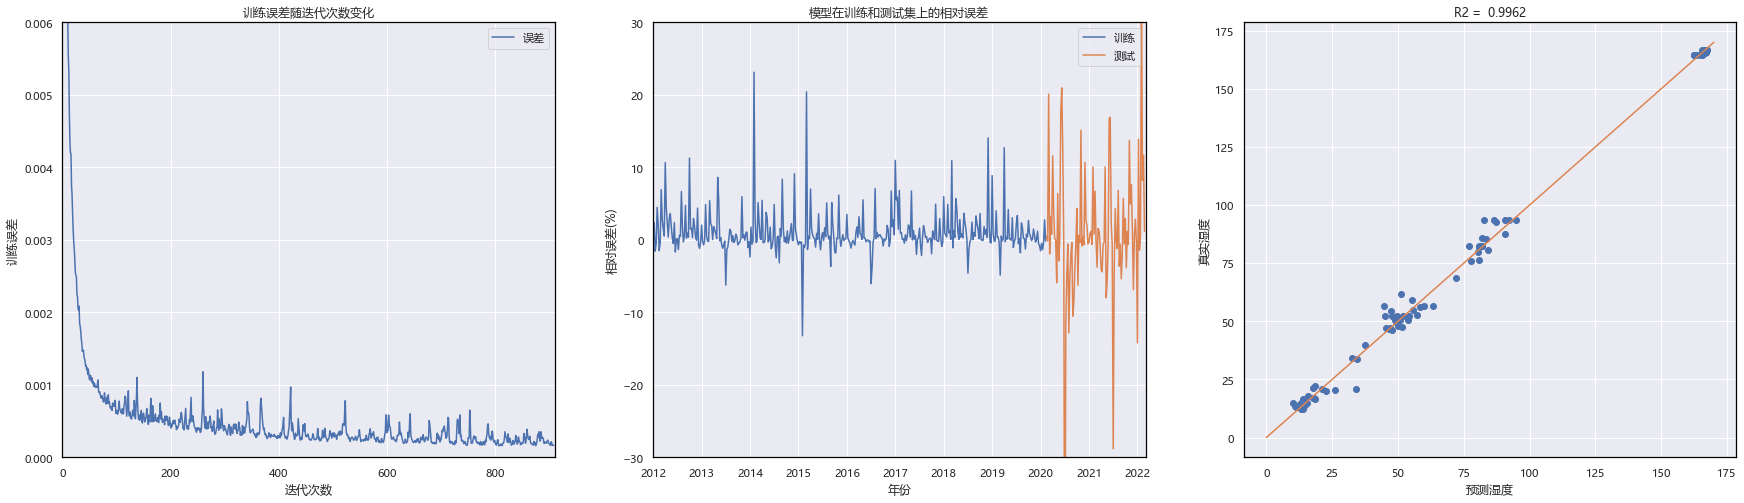

In [26]:
fig, axes = plt.subplots(1, 3, figsize=(30, 8))
## 损失曲线
axes[0].plot(model.loss_curve_, label="误差")
axes[0].set_ylim([0, 0.006])
axes[0].set_xlim([0, 910])
axes[0].set_xlabel("迭代次数")
axes[0].set_ylabel("训练误差")
axes[0].set_title("训练误差随迭代次数变化")
axes[0].legend()

## 误差曲线
axes[1].plot((transform(y_train) - transform(model.predict(X_train))) / transform(y_train)*100, label="训练")
axes[1].plot((transform(y_test) - transform(model.predict(X_test))) / transform(y_test)*100, label="测试")
axes[1].set_xlabel("年份")
axes[1].set_ylabel("相对误差(%)")
axes[1].set_ylim([-30, 30])
axes[1].set_xlim([0, 488])
axes[1].set_title("模型在训练和测试集上的相对误差")
axes[1].set_xticks(ticks=range(0, 488, 48))
axes[1].set_xticklabels(labels=range(2012, 2023))
axes[1].legend()

## R2曲线
axes[2].plot(transform(model.predict(X_test)), transform(y_test), "o")
axes[2].set_xlabel("预测湿度")
axes[2].set_ylabel("真实湿度")
axes[2].plot([0, 170], [0, 170])
axes[2].set_title(f"R2 = {r2_score(transform(y_test), transform(model.predict(X_test))): .4f}")

预测曲线

In [27]:
year = [2020]*10+[2021]*12+[2022]*3
month = list(range(3, 13)) + list(range(1, 13)) + list(range(1, 4))
xticks = [str(year[i])+'/'+str(month[i]) for i in range(len(year))]

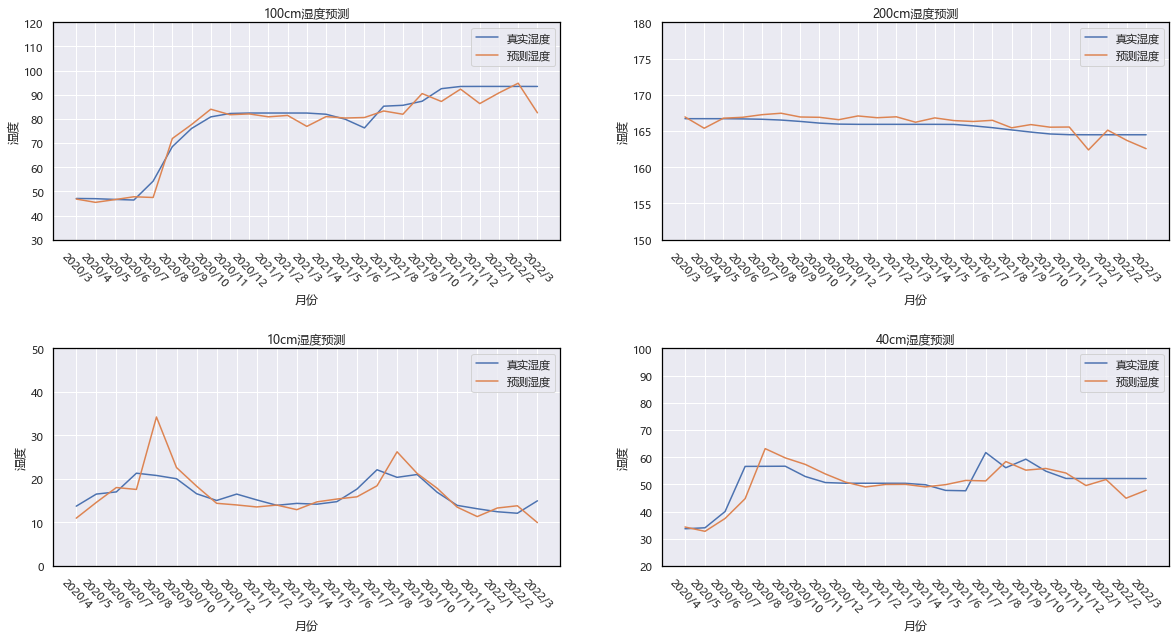

In [28]:
y_test_t, y_pred_t = transform(y_test), transform(model.predict(X_test))

def plot_predict(i, title, ax, ylim=None):
    h_true, h_pred = y_test_t[i::4], y_pred_t[i::4]
    ax.plot(range(len(h_true)), h_true, label="真实湿度")
    ax.plot(range(len(h_pred)), h_pred, label="预测湿度")
    ax.set_xlabel("月份")
    ax.set_ylabel("湿度")
    ax.set_ylim(ylim)
    ax.set_title(title)
    ax.set_xticks(range(len(h_true)))
    ax.set_xticklabels(xticks[-len(h_true):], rotation=-45)
    ax.legend()

fig, axes = plt.subplots(2, 2, figsize=(20, 10))
fig.subplots_adjust(hspace=0.5)
# 预测是从2020年2月开始的, 就是指的2020年3月的湿度
## 10cm湿度预测
plot_predict(0, "100cm湿度预测", axes[0][0], [30, 120])
## 40cm湿度预测
plot_predict(1, "200cm湿度预测", axes[0][1], [150, 180])
## 100cm湿度预测
plot_predict(2, "10cm湿度预测", axes[1][0], [0, 50])
## 200cm湿度预测
plot_predict(3, "40cm湿度预测", axes[1][1], [20, 100])